Importing Libraries

In [28]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Data Preparation 

In [80]:
# Paths for data.
Ravdess = r"C:\Users\xlmq4\Desktop\Hackathon\ravdess-emotional-speech-audio\audio_song_actors_01-24" + "\\"
#os.path.join("ravdess-emotional-speech-audio", "audio_song_actors_01-24")

Ravdess Dataframe

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'ravdess-emotional-speech-audio\\audio_song_actors_01-24Actor_01'

In [57]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,C:\Users\xlmq4\Desktop\Hackathon\ravdess-emoti...
1,neutral,C:\Users\xlmq4\Desktop\Hackathon\ravdess-emoti...
2,neutral,C:\Users\xlmq4\Desktop\Hackathon\ravdess-emoti...
3,neutral,C:\Users\xlmq4\Desktop\Hackathon\ravdess-emoti...
4,calm,C:\Users\xlmq4\Desktop\Hackathon\ravdess-emoti...


plot the count of each emotions in our dataset

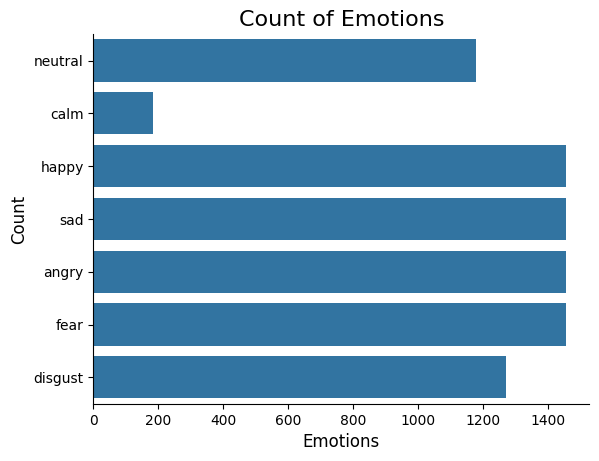

In [33]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

plot waveplots and spectograms for audio signals

In [34]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

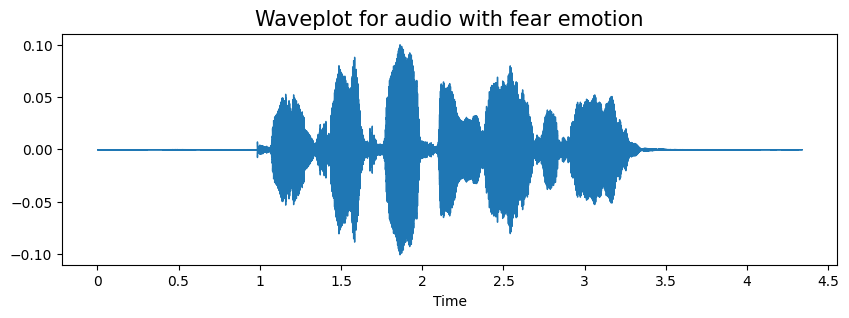

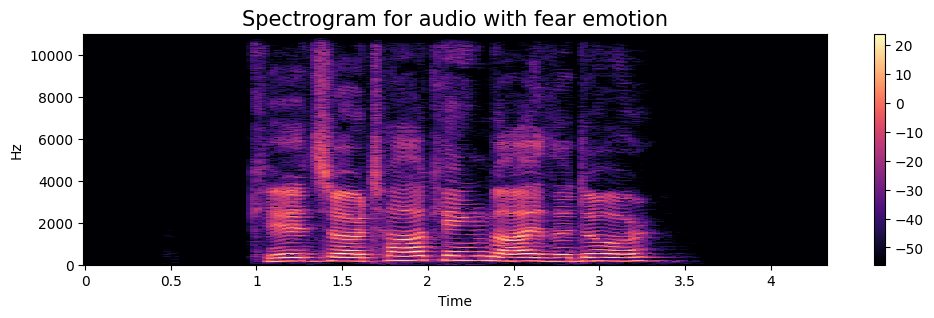

In [35]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
#print(librosa.__version__)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

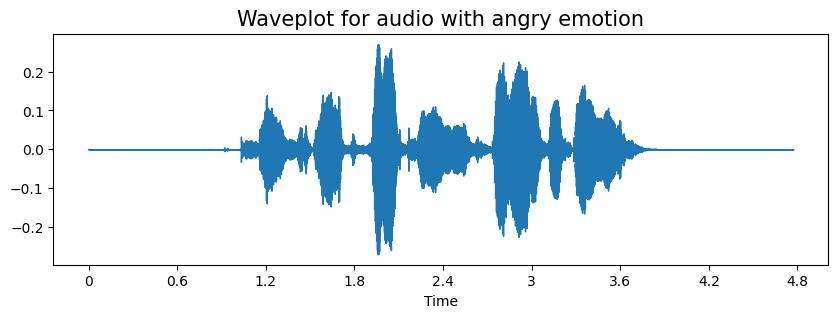

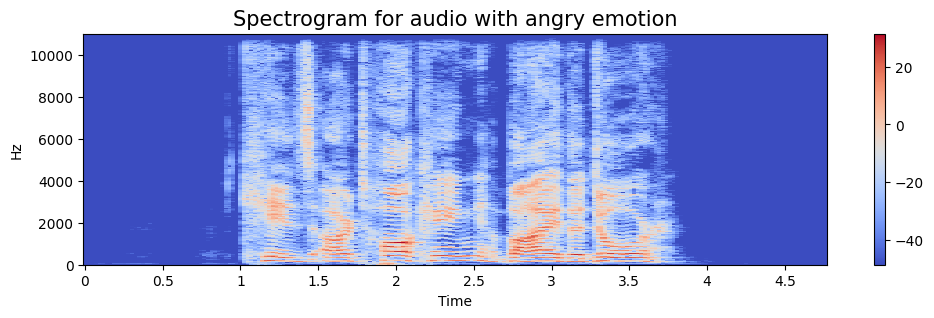

In [36]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

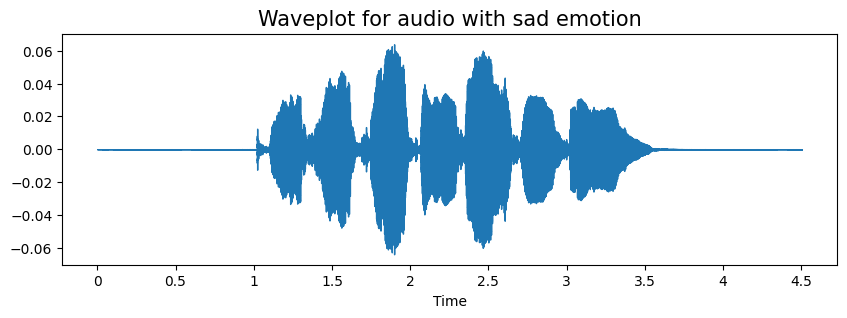

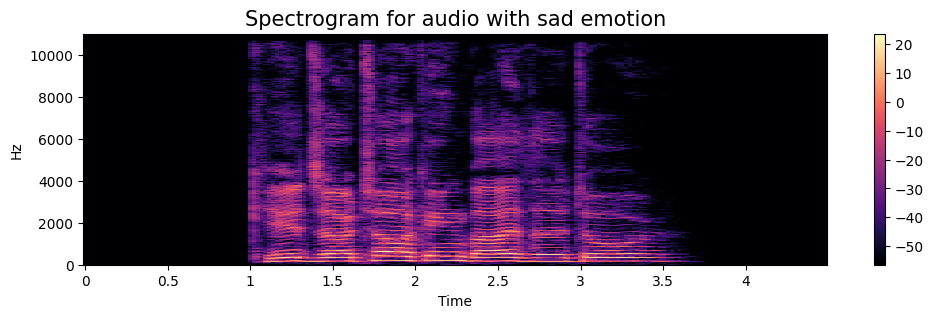

In [26]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

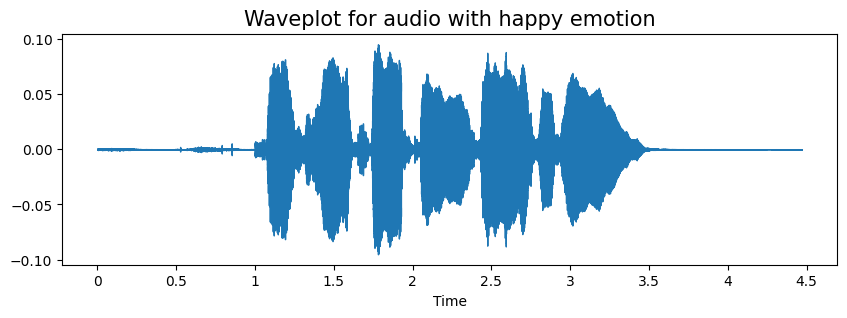

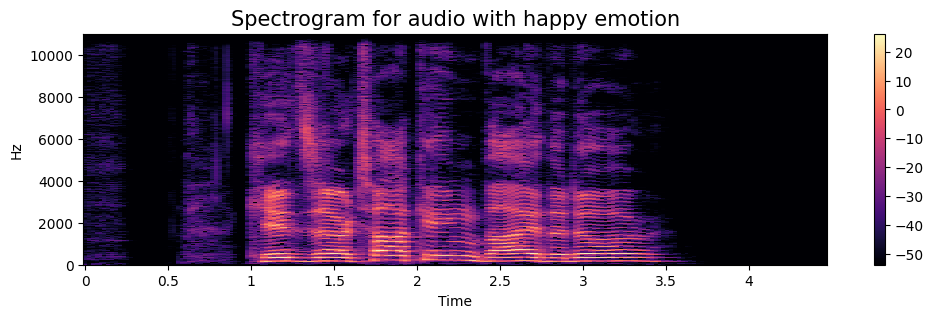

In [27]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

Data Augmentation: 

the process by which we create new synthetic data samples by adding small perturbations on our initial training set

In [50]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

simple audio

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

noise injection

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

stretching

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

shifting

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

pitch

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Feature Extraction

convert the audio data into an understandable format for the model

an audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency

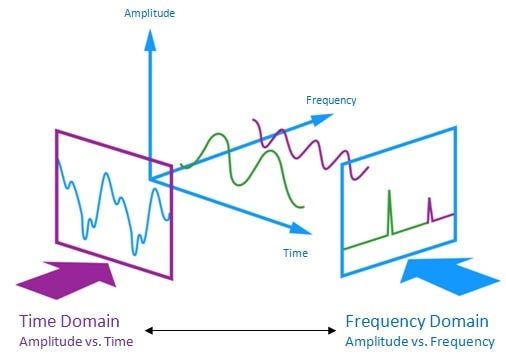

In [59]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [60]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [61]:
len(X), len(Y), data_path.Path.shape


(3036, 3036, (1012,))

In [63]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.166834,0.557366,0.440997,0.558011,0.562937,0.620579,0.680915,0.560372,0.516539,0.430054,...,0.000049,0.000030,0.000023,0.000027,0.000022,0.000023,0.000026,0.000018,1.483300e-06,neutral
1,0.151286,0.613439,0.479062,0.559782,0.573625,0.628532,0.700218,0.578509,0.545958,0.458849,...,0.000070,0.000050,0.000046,0.000049,0.000043,0.000043,0.000048,0.000038,2.254783e-05,neutral
2,0.131149,0.558896,0.542552,0.435233,0.555894,0.544736,0.584994,0.641428,0.510075,0.499044,...,0.000016,0.000014,0.000010,0.000004,0.000006,0.000005,0.000004,0.000003,2.814236e-07,neutral
3,0.175994,0.598417,0.450341,0.492107,0.510895,0.549417,0.690097,0.572404,0.608785,0.493504,...,0.000051,0.000054,0.000033,0.000037,0.000036,0.000042,0.000052,0.000024,2.085746e-06,neutral
4,0.147502,0.610312,0.460105,0.504634,0.519710,0.565004,0.709789,0.576857,0.602033,0.481530,...,0.000051,0.000054,0.000034,0.000037,0.000036,0.000042,0.000052,0.000024,2.113888e-06,neutral


Data Preparation

In [64]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [65]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [66]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2277, 162), (2277, 6), (759, 162), (759, 6))

In [67]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2277, 162), (2277, 6), (759, 162), (759, 6))

In [68]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2277, 162, 1), (2277, 6), (759, 162, 1), (759, 6))

Modeling

In [71]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,222 (2.13 MB)

 Trainable params: 557,222 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.0781 - loss: 1.80 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0938 - loss: 1.800 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1234 - loss: 1.797 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1493 - loss: 1.794 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1680 - loss: 1.787 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1806 - loss: 1.779 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1877 - loss: 1.774 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1932 - loss: 1.770 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1976 - loss: 1.765 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2005 - loss: 1.762 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2036 - loss: 1.758 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2062 - loss: 1.753 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2083 - loss: 1.750 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2106 - loss: 1.746 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8438 - loss: 1.443 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8497 - loss: 0.993 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8465 - loss: 0.890 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8451 - loss: 0.803 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8400 - loss: 0.752 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8379 - loss: 0.7412
Accuracy of our model on test data :  82.21343755722046 %


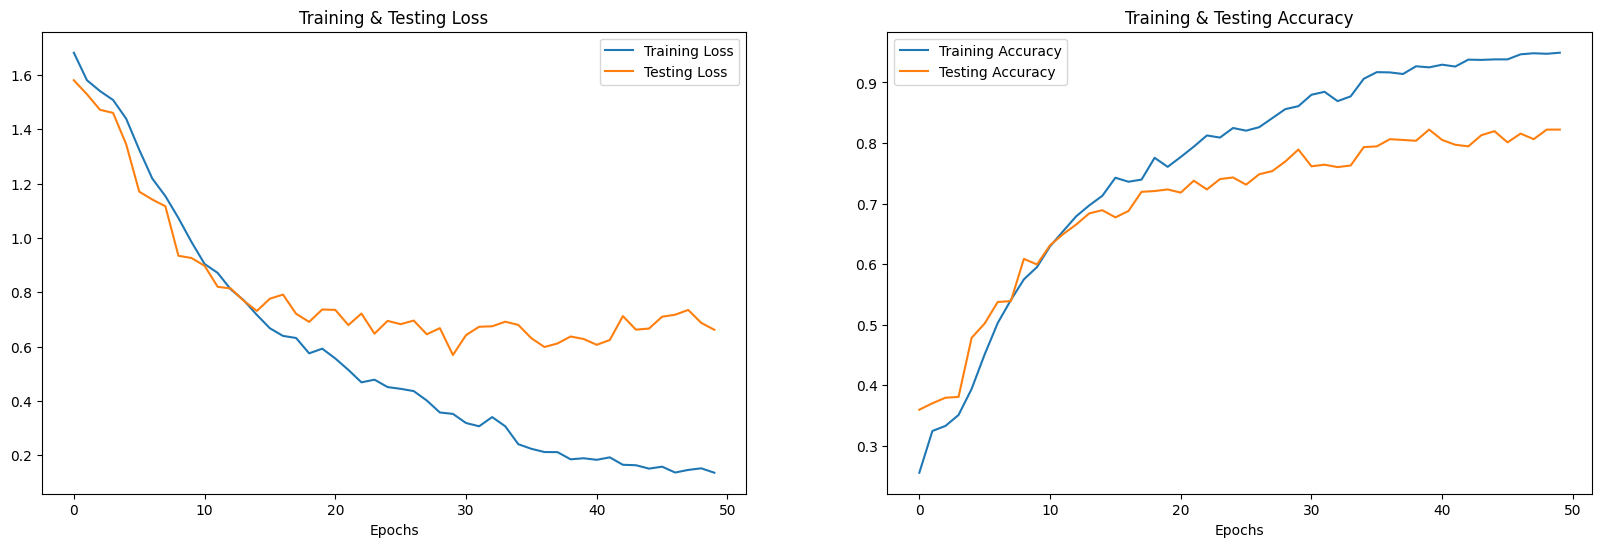

In [73]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [74]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [75]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,neutral,neutral
2,angry,angry
3,sad,calm
4,fear,fear
5,calm,calm
6,calm,calm
7,angry,angry
8,sad,sad
9,sad,fear


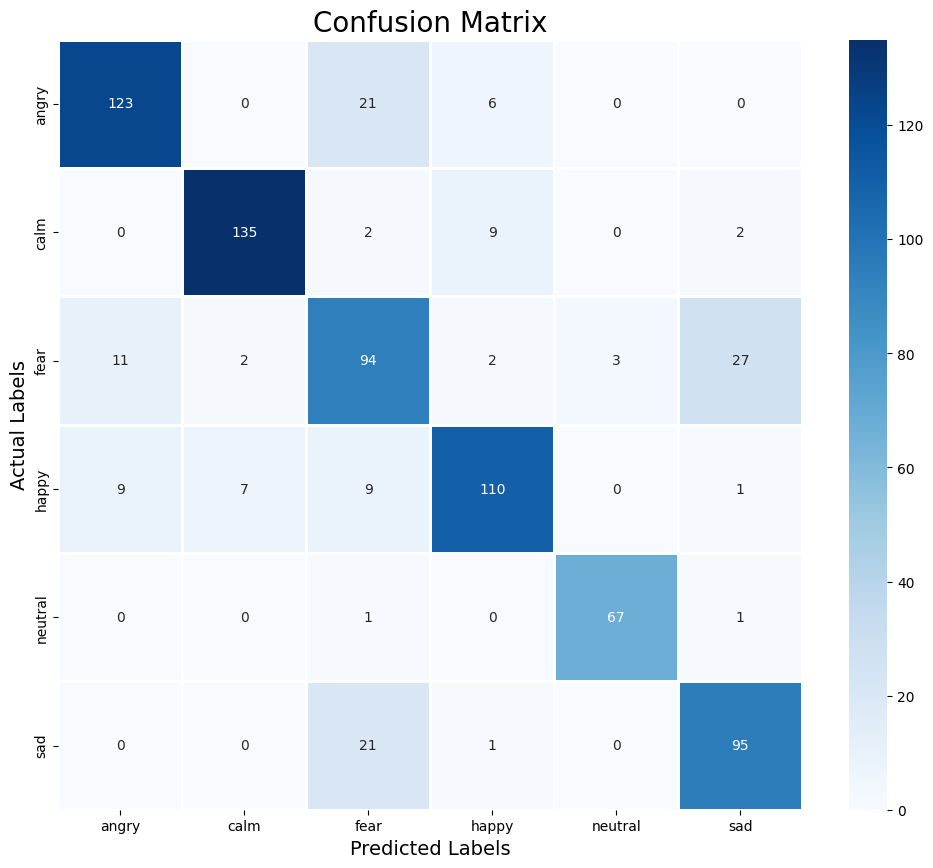

In [76]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [77]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       0.86      0.82      0.84       150
        calm       0.94      0.91      0.92       148
        fear       0.64      0.68      0.66       139
       happy       0.86      0.81      0.83       136
     neutral       0.96      0.97      0.96        69
         sad       0.75      0.81      0.78       117

    accuracy                           0.82       759
   macro avg       0.83      0.83      0.83       759
weighted avg       0.83      0.82      0.82       759

